## Homework 01. Simple text processing.

In [24]:
# general imports
import pandas as pd
import numpy as np
from collections import Counter
from random import sample
import math
from IPython import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from nltk.tokenize import TweetTokenizer

# torch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# word2vec imports
from gensim.models import Word2Vec
from gensim import downloader

# custom file imports
import sys # comment out if not using drive
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/nlp') # comment out if not using drive
import bow_custom
import tfidf_custom

from utils import plot_train_process

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

*Disclaimer: The used dataset may contain obscene language and is used only as an example of real unfiltered data.*

In [ ]:
# In colab uncomment this cell
! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [ ]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [9]:
# split the data into train and test 
texts = data['comment_text'].values
target = data['should_ban'].values
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [10]:
# tokenize the test and train texts
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))
texts_train = [' '.join(tokenizer.tokenize(x.lower())) for x in texts_train]
texts_test = [' '.join(tokenizer.tokenize(x.lower())) for x in texts_test]

In [11]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [12]:
k = min(10000, len(set(' '.join(texts_train).split())))
bow = bow_custom.Bow(texts_train, k)

X_train_bow = np.stack(list(map(bow.text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(bow.text_to_bow, texts_test)))

In [13]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow.bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow.bow_vocabulary.index('.')] == texts_train[6].split().count('.') 

Now let's do the trick with `sklearn` logistic regression implementation:

In [23]:
def graph_roc_auc(X_train, X_test, y_train, y_test, input_model, torched=False):
  for name, X, y, model in [
      ('train', X_train, y_train, input_model),
      ('test ', X_test, y_test, input_model)
  ]:
      proba = model(torch.tensor(X)).detach().cpu().numpy()[:, 1] if torched else model.predict_proba(X)[:, 1]
      auc = roc_auc_score(y, proba)
      plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

  plt.plot([0, 1], [0, 1], '--', color='black',)
  plt.legend(fontsize='large')
  plt.grid()

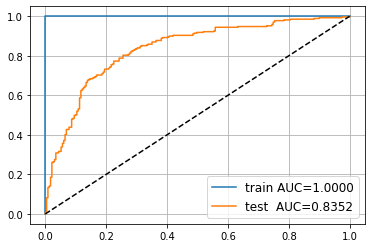

In [15]:
# train the logistic regression model
bow_model = LogisticRegression().fit(X_train_bow, y_train)
# graph roc-auc of logistic regression model
graph_roc_auc(X_train_bow, X_test_bow, y_train, y_test, bow_model)

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [20]:
# build log regression's model architecture using torch
torch_log_reg_model = nn.Sequential()
torch_log_reg_model.add_module('l1', torch.nn.Linear(len(bow.bow_vocabulary), 2))

# loss function and optimizer to use in the model
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(torch_log_reg_model.parameters(), lr=0.001)

# cast train and test data to torch tensors
X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)
y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [21]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()        

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

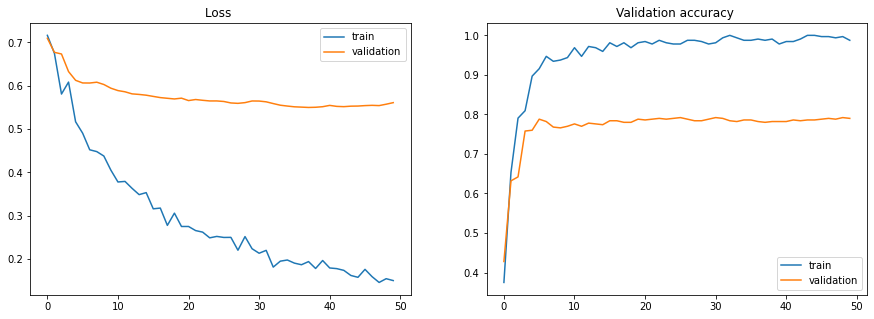

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


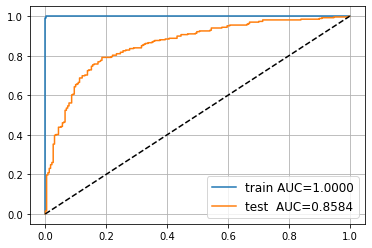

In [25]:
# train torch implementation of logistic regression
lr_scheduler =  StepLR(opt, step_size=1, gamma=0.1)
train_model(torch_log_reg_model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)
graph_roc_auc(X_train_bow_torch, X_test_bow_torch, y_train, y_test, torch_log_reg_model, torched=True)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [26]:
def check_auc_for_k(k):
  # create bow vocabulary
  total_vocabulary = Counter(' '.join(texts_train).split())
  k_common_words = total_vocabulary.most_common(k)
  flattened_word_count = list(sum(k_common_words,()))
  bow_vocabulary = flattened_word_count[0:][::2]
  
  def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    token_counts = np.zeros(k)
    for word in text.split():
      if word in bow_vocabulary:
        token_counts[bow_vocabulary.index(word)] += 1
    return np.array(token_counts, 'float32')

  # apply bow vocabulary to text
  X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
  X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

  # cast to torch tensors
  X_train_bow_torch = torch.tensor(X_train_bow)
  X_test_bow_torch = torch.tensor(X_test_bow)
  y_train_torch = torch.tensor(y_train)
  y_test_torch = torch.tensor(y_test)

  # train the model with a given k tokens
  model = nn.Sequential()
  model.add_module('l1', torch.nn.Linear(k, 2))
  loss_function = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters(), lr=0.001)
  train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

  # get the auc score 
  proba = model(X_train_bow_torch).detach().cpu().numpy()[:, 1]
  auc_train = roc_auc_score(y_train, proba)
  proba = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
  auc_test = roc_auc_score(y_test, proba)

  return auc_train, auc_test

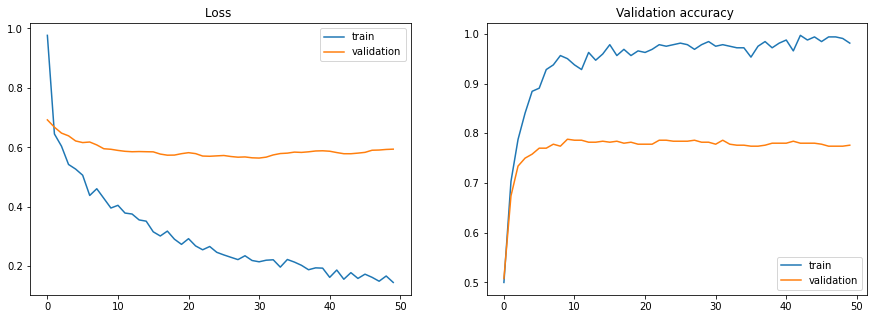

For k = 20. Train_auc: 0.681 Test_auc: 0.708
For k = 50. Train_auc: 0.764 Test_auc: 0.743
For k = 100. Train_auc: 0.791 Test_auc: 0.721
For k = 250. Train_auc: 0.931 Test_auc: 0.803
For k = 500. Train_auc: 0.970 Test_auc: 0.828
For k = 1000. Train_auc: 0.990 Test_auc: 0.849
For k = 1500. Train_auc: 0.995 Test_auc: 0.852
For k = 2000. Train_auc: 0.998 Test_auc: 0.853
For k = 3000. Train_auc: 0.999 Test_auc: 0.844
For k = 4000. Train_auc: 0.998 Test_auc: 0.852
For k = 5000. Train_auc: 1.000 Test_auc: 0.847


In [27]:
# different k-values for bag of words for testing
k_values = [20, 50, 100, 250, 500, 1000, 1500, 2000, 3000, 4000, 5000]
auc_trains = []
auc_tests = []

# train log-reg model with different k-values of bow and compare ROC-AUCs
for k in k_values:
  temp_train_auc, temp_test_auc = check_auc_for_k(k)
  auc_trains.append(temp_train_auc)
  auc_tests.append(temp_test_auc)

# print obtained ROC-AUCs 
for i in range(len(k_values)):
  print(f'For k = {k_values[i]}. Train_auc: {auc_trains[i]:.3f} Test_auc: {auc_tests[i]:.3f}')

Text(0.5, 1.0, 'ROC-AUC vs number of words in BOW')

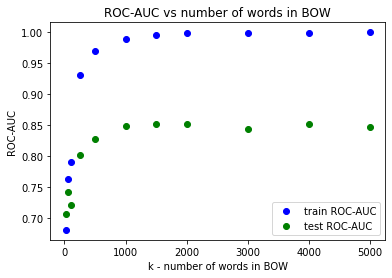

In [28]:
# graph the change in ROC-AUC with the change in k
plt.scatter(k_values, auc_trains, color='blue')
plt.scatter(k_values, auc_tests, color='green')
plt.xlabel('k - number of words in BOW')
plt.ylabel('ROC-AUC')
plt.legend(['train ROC-AUC', 'test ROC-AUC'])
plt.title('ROC-AUC vs number of words in BOW')

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [29]:
# get tf-idf for test and train data
tfidf = tfidf_custom.TfIdf(texts_train)
X_train_tfidf = tfidf.transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

# cast dataset to torch tensors
X_train_tfidf_torch = torch.tensor(X_train_tfidf)
X_test_tfidf_torch = torch.tensor(X_test_tfidf)
y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

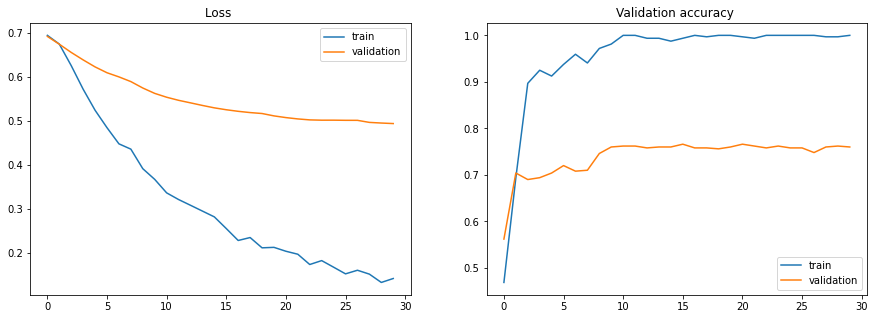

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


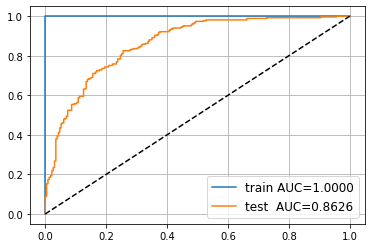

In [30]:
# logistic regression with tf-idf data
model_tfidf = nn.Sequential()
model_tfidf.add_module('l1', torch.nn.Linear(X_train_tfidf_torch.shape[1], 2))
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_tfidf.parameters(), lr=0.01)
lr_scheduler =  StepLR(opt, step_size=10, gamma=0.1)
train_model(model_tfidf, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=300)
graph_roc_auc(X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, model_tfidf, torched=True)

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

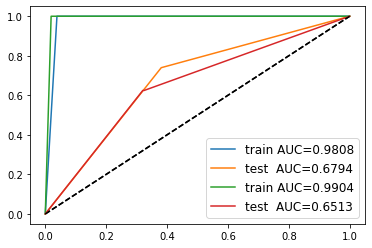

In [31]:
# naive bayes model for bag of words
nb_bow = GaussianNB()
y_pred_bow = nb_bow.fit(X_train_bow, y_train).predict(X_test_bow)

# naive bayes model for tf-idf
nb_tfidf = GaussianNB()
y_pred_tfidf = nb_tfidf.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

# graph roc-auc for naive bayes models
graph_roc_auc(X_train_bow, X_test_bow, y_train, y_test, nb_bow)
graph_roc_auc(X_train_tfidf, X_test_tfidf, y_train, y_test, nb_tfidf)

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

### Conclusions

BOW and Logistic Regression. The model gave the ROC-AUC score of 0.83-0.85<br> <br>
BOW (with different k values) and Logistic Regression. At very low k we can see very low values on ROC-AUC, and with an increase in k ROC-AUC increases. Interestingly after reaching vocabulary of 200-500 words the ROC-AUC score starts to saturate and score doesn't really improve. It is probably because our train set is small and some words rarely occur. Hence, we don't get improvements in our model over some period of time. <br> <br>
TF-IDF and Logistic Regression. I expected TF-IDF to work better than BOW, but the model performance is not significantly different. It only gave an improvement of 0.1 on ROC-AUC after process of tuning the learning rate and learning rate schedule. Starting of with a high learning rate of 0.1 led to a bad model that performed worse than BOW based model. Adjusting learning rate schedule didn't affect anything significantly. I suppose it's because the training dataset is small and model adjusts to things pretty quickly.<br> <br>
BOW, TF-IDF and Naive Bayes. Naive Bayes didn't perform well on the test set because our training dataset is small and it is hard for Naive Bayes to work well in this case. <br> <br>


### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [ ]:
# download small word2vec model
word_2_vec_model = downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# count tokens on train data
token_counts = Counter()
for row in np.array(texts_train).flatten():
    token_counts.update(row.split())

# remove tokens that we occur only once
min_count = 2
tokens = [token for token, counts in token_counts.items() if counts >= min_count] 

In [ ]:
# padding and unknown tokens for word2vec
UNK, PAD = np.zeros(25), np.ones(25)

# function to cast data to word2vec representation
def to_word2vec_rep(data, max_len=20):
  data_rep = []
  for text in data:
    #pdb.set_trace()
    cut_text = text.split()[:max_len]
    count = 0
    cur_text_rep = []
    while count < max_len:
      if count < len(cut_text):
        try:
          cur_text_rep.append(word_2_vec_model[cut_text[count]])
        except:
          cur_text_rep.append(UNK)
      else:
        cur_text_rep.append(PAD)
      count += 1
    data_rep.append(np.array(cur_text_rep, 'float32'))
  return np.array(data_rep)

# cast train and test data to word2vec
x_train_word_vec, x_test_word_vec = to_word2vec_rep(texts_train), to_word2vec_rep(texts_test)

In [ ]:
### function needed for training the neural model
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [ ]:
# function for iterating over batches
def iterate_minibatches(data, target_data, batch_size=32, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = data[start : start + batch_size]
            target = target_data[start : start + batch_size]
            yield batch, target
        
        if not cycle: break

In [ ]:
### CNN model architecture for training word2vec data
# parameters
n_tokens = len(tokens)
hid_size = 25
n_maximums = 2
simple_model = nn.Sequential()

# blocks of architecture
simple_model.add_module('reorder', Reorder())
simple_model.add_module('conv1', nn.Conv1d(
    in_channels=hid_size,
    out_channels=hid_size*2,
    kernel_size=2
))
simple_model.add_module('relu1', nn.ReLU())
simple_model.add_module('conv2', nn.Conv1d(
    in_channels=hid_size*2,
    out_channels=hid_size*2,
    kernel_size=3
))
simple_model.add_module('bn1', nn.BatchNorm1d(hid_size*2))
simple_model.add_module('relu2', nn.ReLU())
simple_model.add_module('adaptive_pool', nn.AdaptiveMaxPool1d(n_maximums))
simple_model.add_module('flatten', nn.Flatten())
simple_model.add_module('out', nn.Linear(hid_size*2*n_maximums, 2))

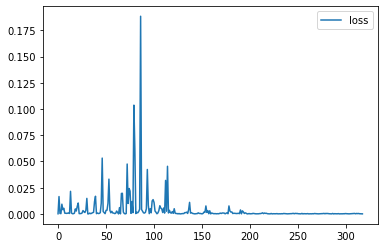

In [ ]:
### train the CNN model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 10
model = simple_model
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss() 

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(x_train_word_vec, y_train, batch_size=16)):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch).to(device)
        target = torch.tensor(target, dtype=torch.long).to(device)

        predictions = model(batch)

        loss = loss_func(predictions, target) 
        
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.item())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()

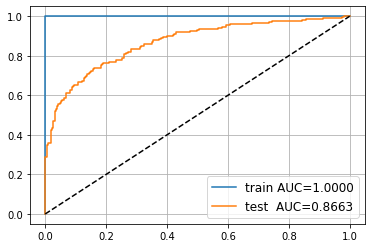

In [ ]:
# graph roc_auc of CNN model
simple_model.eval()
graph_roc_auc(x_train_word_vec, x_test_word_vec, y_train, y_test, simple_model, torched=True)

### Conclusion

Word2Vec and CNN. This model showed similar performance metrics compared to logistic regression model before. I think there is no significant improvement in the quality because twitter dataset I got from word2vec might not contain all those obscene words used in our dataset (when I looked at words in the dataset there were a lot of weird words that people used to insult each other, and those words are usually present in general vocabulary) 